<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/GAN_mnist_LSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [899]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [900]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

In [901]:
x_train.shape[0]

60000

In [902]:
batch_size = 256
noise_dim = 100
lr = 1e-4

In [903]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).shuffle(x_test.shape[0]).batch(batch_size)
test_data

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

generator = Generator(gen_net=gen_net, noise=noise, optimizer=optimizer)

In [904]:
class GAN(keras.Model):

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.generator = Sequential(self.gen_nn)    
        self.discriminator = Sequential(self.dis_nn)
        self.cross_entropy = self.cross_entropy
        self.noise_z = self.noise

    def Generator(self, x, training):
        if training == True:
            gen = self.generator(x, training=True)
        else:
            gen = self.generator(x, training=False)
        return gen 

    def Discriminator(self, x):
        dis = self.discriminator(x, training=True)
        return dis

    @tf.function
    def dis_loss(self, real_output, fake_output):
        # total_loss = -tf.reduce_sum(tf.math.log(real_output) + tf.math.log(tf.ones_like(fake_output) - fake_output))

        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def gen_loss(self, fake_output):
        # loss = -tf.reduce_mean(tf.math.log(fake_output))
        
        loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
        return loss

        
    @tf.function
    def compute_gradient(self, x):
        noise = self.noise_z

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            generated_img = self.Generator(noise, True)

            real_output = self.Discriminator(x)
            fake_output = self.Discriminator(generated_img)

            loss_gen = self.gen_loss(fake_output)
            loss_dis = self.dis_loss(real_output, fake_output)

        gradient_gen = gen_tape.gradient(loss_gen, self.generator.trainable_variables)
        gradient_dis = dis_tape.gradient(loss_dis, self.discriminator.trainable_variables)

        return gradient_gen, gradient_dis, loss_gen, loss_dis

    @tf.function
    def train(self, x):
        gradient_gen, gradient_dis, loss_gen, loss_dis = self.compute_gradient(x)
        self.gen_optimizer.apply_gradients(zip(gradient_gen, self.generator.trainable_variables))
        self.dis_optimizer.apply_gradients(zip(gradient_dis, self.discriminator.trainable_variables))
        return loss_gen, loss_dis



In [905]:
# sigmoid 사용
'''DC GAN'''
gen_nn = [Dense(7*7*256, input_shape=(100,)),
          BatchNormalization(),
          LeakyReLU(),
          
          Reshape((7,7,256)),
          Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid'),
          ]

dis_nn = [Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
          LeakyReLU(),
          Dropout(0.3),
          
          Flatten(),
          Dense(1)]

'''GAN'''
gen_nn_Dense = [
          Dense(256, input_dim=100,activation='relu'),
          
          Dense(512, activation='relu'),
          
          Dense(1024, activation='relu'),
          
          Dense(784, activation='sigmoid'),
          Reshape((28,28,1))]


dis_nn_Dense = [InputLayer(input_shape=(28, 28, 1)),
                Reshape((-1, 784)),
                Dense(1024, input_dim=784),
                LeakyReLU(),
                Dropout(0.3),

                Dense(512),
                LeakyReLU(),
                Dropout(0.3),

                Dense(256),
                LeakyReLU(),
                Dropout(0.3),

                Flatten(),
                Dense(1)
                ]


In [906]:
'''Gan fashion'''
gen = [Dense(7*7*256, activation='relu'),
       Reshape((7,7,256)),
       Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False, activation='relu'),
       Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False, activation='relu'),
       Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid'),
       ]

dis = [Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1], activation='relu'),
          
       Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),
                
       Flatten(),
       Dense(1)]

In [907]:
gen_optimizer = optimizers.Adam(0.001, beta_1=0.5)
dis_optimizer = optimizers.RMSprop(0.005)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
noise = tf.random.normal([batch_size, noise_dim])

In [908]:
gen_network = GAN(gen_nn=gen_nn_Dense, 
                  dis_nn=dis_nn_Dense, 
                  noise=noise, 
                  gen_optimizer=gen_optimizer, 
                  dis_optimizer=dis_optimizer, 
                  cross_entropy=cross_entropy)

In [909]:
# gen_network.generator.summary()

In [910]:
gen_network.discriminator.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_155 (Reshape)        (None, 1, 784)            0         
_________________________________________________________________
dense_598 (Dense)            (None, 1, 1024)           803840    
_________________________________________________________________
leaky_re_lu_569 (LeakyReLU)  (None, 1, 1024)           0         
_________________________________________________________________
dropout_400 (Dropout)        (None, 1, 1024)           0         
_________________________________________________________________
dense_599 (Dense)            (None, 1, 512)            524800    
_________________________________________________________________
leaky_re_lu_570 (LeakyReLU)  (None, 1, 512)            0         
_________________________________________________________________
dropout_401 (Dropout)        (None, 1, 512)         

In [911]:
# geerate random noise img
noise_ = tf.random.normal([1, 100])
generated_img = gen_network.Generator(noise_, False)
# plt.imshow(generated_img[0, :, :, 0], cmap='gray')


In [912]:
# decision = gen_network.Discriminator(generated_img)
# decision

In [913]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')

In [914]:
def show_generated_img(model, epoch, test_data):
    predict = model.Generator(test_data, False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predict.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [915]:
def show_loss(gen, dis, tgen, tdis, epoch):
    plt.plot(epoch, gen, label='gen train')
    # plt.plot(epoch, tgen, label='gen test')
    plt.plot(epoch, dis, label='dis train')
    # plt.plot(epoch, tdis, label='dis test')
    plt.legend()
    plt.show()


Epoch: 0, Gen[train]: 21.474172592163086, Dis[train]: 22.639629364013672, Gen[test]: 14.756993293762207, Dis[test]: 5.184165000915527 


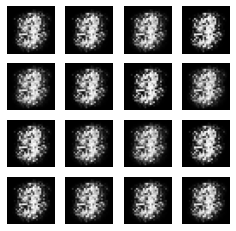

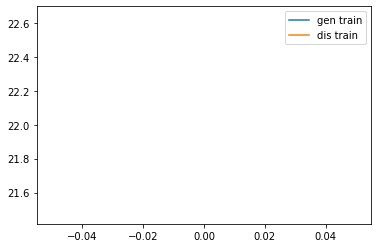

time: 4.901299715042114 
Epoch: 1, Gen[train]: 1.9129565954208374, Dis[train]: 2.004056453704834, Gen[test]: 1.4803662300109863, Dis[test]: 0.34007197618484497 
Epoch: 2, Gen[train]: 3.35023832321167, Dis[train]: 1.892272710800171, Gen[test]: 2.104339599609375, Dis[test]: 0.3737112283706665 
Epoch: 3, Gen[train]: 2.7858469486236572, Dis[train]: 1.4281915426254272, Gen[test]: 1.6025127172470093, Dis[test]: 0.45399290323257446 
Epoch: 4, Gen[train]: 2.1783130168914795, Dis[train]: 1.3312771320343018, Gen[test]: 1.184029221534729, Dis[test]: 0.676308274269104 
Epoch: 5, Gen[train]: 1.957873821258545, Dis[train]: 1.6749659776687622, Gen[test]: 0.4880828857421875, Dis[test]: 1.211773157119751 


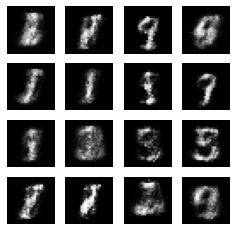

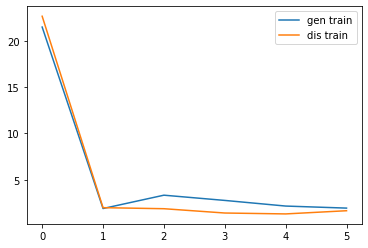

time: 14.401769161224365 
Epoch: 6, Gen[train]: 2.1401612758636475, Dis[train]: 2.0199477672576904, Gen[test]: 0.019486326724290848, Dis[test]: 7.338057518005371 
Epoch: 7, Gen[train]: 2.1343557834625244, Dis[train]: 1.6724194288253784, Gen[test]: 3.2964279651641846, Dis[test]: 1.815471887588501 
Epoch: 8, Gen[train]: 1.9353160858154297, Dis[train]: 2.126805067062378, Gen[test]: 2.4299302101135254, Dis[test]: 0.8390820622444153 
Epoch: 9, Gen[train]: 2.4535439014434814, Dis[train]: 2.1688449382781982, Gen[test]: 1.650421380996704, Dis[test]: 0.631432056427002 
Epoch: 10, Gen[train]: 1.92453134059906, Dis[train]: 1.9448224306106567, Gen[test]: 2.688023090362549, Dis[test]: 1.717214584350586 


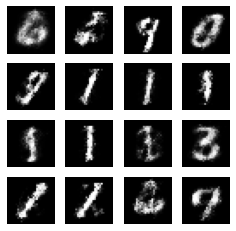

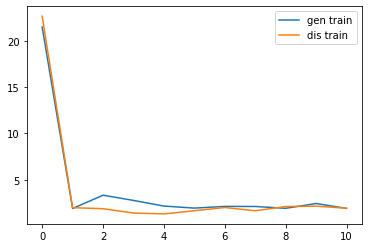

time: 23.82713270187378 
Epoch: 11, Gen[train]: 1.9645682573318481, Dis[train]: 2.2331626415252686, Gen[test]: 1.423974871635437, Dis[test]: 0.6977664232254028 
Epoch: 12, Gen[train]: 1.7604150772094727, Dis[train]: 1.9024289846420288, Gen[test]: 4.990072727203369, Dis[test]: 2.6959826946258545 
Epoch: 13, Gen[train]: 2.1600935459136963, Dis[train]: 2.3061678409576416, Gen[test]: 0.5026064515113831, Dis[test]: 2.1069982051849365 
Epoch: 14, Gen[train]: 1.9955196380615234, Dis[train]: 2.1879804134368896, Gen[test]: 1.1883808374404907, Dis[test]: 0.9108728170394897 
Epoch: 15, Gen[train]: 1.7327247858047485, Dis[train]: 2.0893149375915527, Gen[test]: 1.7367435693740845, Dis[test]: 1.4821436405181885 


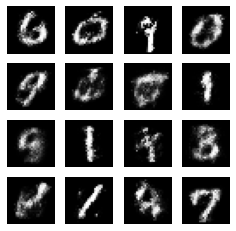

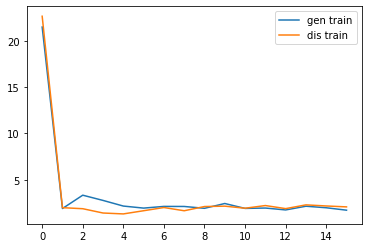

time: 33.13622260093689 
Epoch: 16, Gen[train]: 2.2503278255462646, Dis[train]: 2.749035596847534, Gen[test]: 1.6172584295272827, Dis[test]: 0.7234129905700684 
Epoch: 17, Gen[train]: 1.7478137016296387, Dis[train]: 1.9440945386886597, Gen[test]: 1.8643391132354736, Dis[test]: 1.5700165033340454 
Epoch: 18, Gen[train]: 1.6239497661590576, Dis[train]: 2.078139066696167, Gen[test]: 2.7361788749694824, Dis[test]: 1.5735737085342407 
Epoch: 19, Gen[train]: 1.5233622789382935, Dis[train]: 2.305562734603882, Gen[test]: 0.9024674296379089, Dis[test]: 1.101941704750061 
Epoch: 20, Gen[train]: 1.8478740453720093, Dis[train]: 2.567434549331665, Gen[test]: 2.2639341354370117, Dis[test]: 1.0775949954986572 


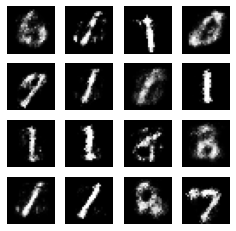

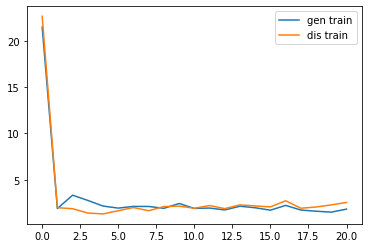

time: 42.60007834434509 
Epoch: 21, Gen[train]: 2.273306369781494, Dis[train]: 2.6492152214050293, Gen[test]: 1.8065624237060547, Dis[test]: 1.485835313796997 
Epoch: 22, Gen[train]: 1.7730273008346558, Dis[train]: 2.3047900199890137, Gen[test]: 3.142063617706299, Dis[test]: 1.942580223083496 
Epoch: 23, Gen[train]: 1.8372113704681396, Dis[train]: 2.5285744667053223, Gen[test]: 1.3464460372924805, Dis[test]: 0.9629804491996765 
Epoch: 24, Gen[train]: 2.2523984909057617, Dis[train]: 2.8393445014953613, Gen[test]: 4.527029991149902, Dis[test]: 5.246044635772705 
Epoch: 25, Gen[train]: 1.8037991523742676, Dis[train]: 2.386381149291992, Gen[test]: 2.059471607208252, Dis[test]: 1.0008151531219482 


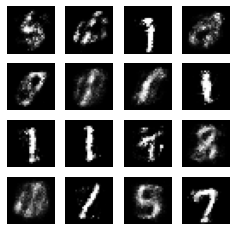

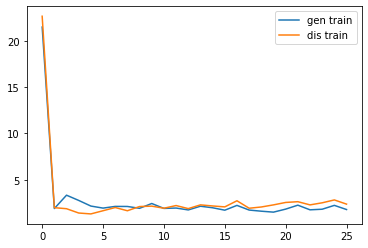

time: 51.96481418609619 
Epoch: 26, Gen[train]: 1.7940373420715332, Dis[train]: 2.3056159019470215, Gen[test]: 0.5752565264701843, Dis[test]: 2.2038047313690186 
Epoch: 27, Gen[train]: 1.8456828594207764, Dis[train]: 2.4485208988189697, Gen[test]: 1.7290722131729126, Dis[test]: 1.1208317279815674 
Epoch: 28, Gen[train]: 1.7393040657043457, Dis[train]: 2.3908021450042725, Gen[test]: 0.38291698694229126, Dis[test]: 1.7963708639144897 
Epoch: 29, Gen[train]: 1.978223443031311, Dis[train]: 2.784203052520752, Gen[test]: 0.8884544372558594, Dis[test]: 1.101664423942566 
Epoch: 30, Gen[train]: 1.5291402339935303, Dis[train]: 2.078364372253418, Gen[test]: 2.8885488510131836, Dis[test]: 2.32674503326416 


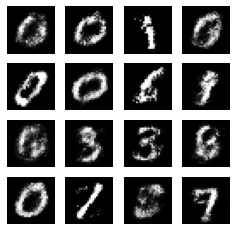

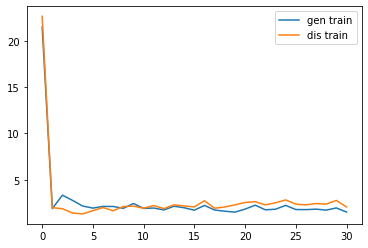

time: 61.309433937072754 
Epoch: 31, Gen[train]: 2.2385926246643066, Dis[train]: 2.8047189712524414, Gen[test]: 0.6886911988258362, Dis[test]: 1.2074345350265503 
Epoch: 32, Gen[train]: 2.0033578872680664, Dis[train]: 2.7712063789367676, Gen[test]: 1.0754013061523438, Dis[test]: 1.1073029041290283 
Epoch: 33, Gen[train]: 1.8056728839874268, Dis[train]: 2.270373821258545, Gen[test]: 1.7360044717788696, Dis[test]: 1.1533679962158203 
Epoch: 34, Gen[train]: 1.6015101671218872, Dis[train]: 2.2459168434143066, Gen[test]: 2.914607286453247, Dis[test]: 4.078271865844727 
Epoch: 35, Gen[train]: 1.7487033605575562, Dis[train]: 2.5648398399353027, Gen[test]: 1.5320498943328857, Dis[test]: 1.121363878250122 


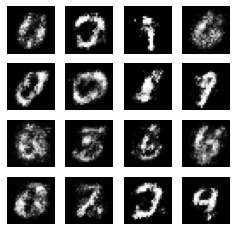

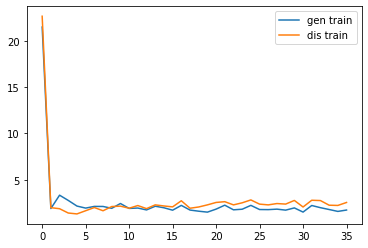

time: 70.87480163574219 
Epoch: 36, Gen[train]: 1.9954583644866943, Dis[train]: 2.6050333976745605, Gen[test]: 1.5311148166656494, Dis[test]: 0.8545827865600586 
Epoch: 37, Gen[train]: 2.027026653289795, Dis[train]: 2.5047852993011475, Gen[test]: 8.22892951965332, Dis[test]: 9.635571479797363 
Epoch: 38, Gen[train]: 2.277190685272217, Dis[train]: 2.8303725719451904, Gen[test]: 0.895756721496582, Dis[test]: 1.0371861457824707 
Epoch: 39, Gen[train]: 1.9178913831710815, Dis[train]: 2.3479509353637695, Gen[test]: 1.926266074180603, Dis[test]: 1.4049365520477295 
Epoch: 40, Gen[train]: 2.324090003967285, Dis[train]: 2.708857297897339, Gen[test]: 0.5326014757156372, Dis[test]: 2.0325520038604736 


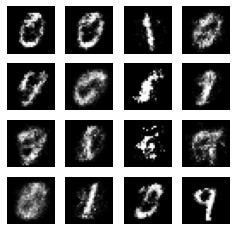

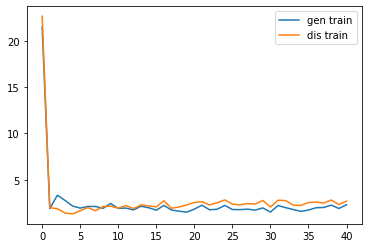

time: 80.26036357879639 
Epoch: 41, Gen[train]: 2.1787071228027344, Dis[train]: 2.928647041320801, Gen[test]: 1.360378384590149, Dis[test]: 0.8850157856941223 
Epoch: 42, Gen[train]: 1.9711322784423828, Dis[train]: 2.4658570289611816, Gen[test]: 1.5093481540679932, Dis[test]: 0.8031685948371887 
Epoch: 43, Gen[train]: 2.071382761001587, Dis[train]: 2.5413544178009033, Gen[test]: 0.9781768918037415, Dis[test]: 0.972474217414856 
Epoch: 44, Gen[train]: 1.9510663747787476, Dis[train]: 2.340116024017334, Gen[test]: 1.1954209804534912, Dis[test]: 0.9107815623283386 


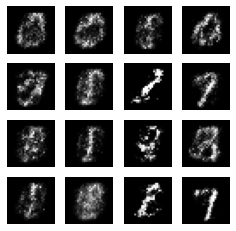

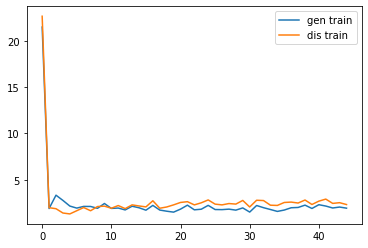

time: 87.83839535713196 


In [916]:
import time
display_step = 5
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_range = 45
gen_loss_arr = []
dis_loss_arr = []
gen_tloss_arr = []
dis_tloss_arr = []
EPOCH=[]

strat_time = time.time()
for epoch in range(train_range):
    for x_batch in train_data:
        gen_loss, dis_loss = gen_network.train(x_batch)
        train_gen_loss(gen_loss)
        train_dis_loss(dis_loss)

    for x_batch in test_data:
        a,b, loss_gen_t, loss_dis_t = gen_network.compute_gradient(x_batch)
        test_gen_loss(loss_gen_t)
        test_dis_loss(loss_dis_t)
    
    gen_loss_arr.append(train_gen_loss.result())
    dis_loss_arr.append(train_dis_loss.result())
    gen_tloss_arr.append(test_gen_loss.result())
    dis_tloss_arr.append(test_dis_loss.result())
    EPOCH.append(epoch)


    print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Gen[test]: {test_gen_loss.result()}, Dis[test]: {test_dis_loss.result()} ')

    if epoch % display_step == 0 or epoch == (train_range - 1):
        show_generated_img(gen_network, epoch + 1, seed)
        show_loss(gen_loss_arr, dis_loss_arr, gen_tloss_arr, dis_tloss_arr, EPOCH)
        print(f'time: {time.time() - strat_time} ')

    train_gen_loss.reset_states()
    train_dis_loss.reset_states()
    test_gen_loss.reset_states()
    test_dis_loss.reset_states()
    # dis가 빨리 학습해서 gen이 잘 안나온다.